# **Recommender Systems**


    



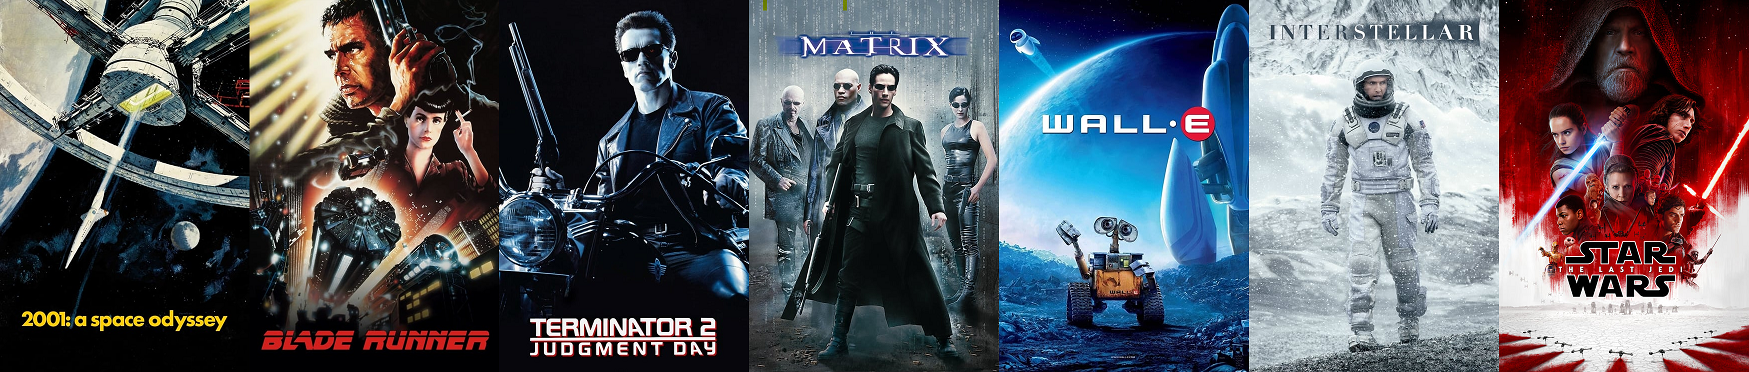

<a href="https://colab.research.google.com/github/deep-learning-indaba/indaba-pracs-2024/blob/main/practicals/Recommender_Systems/Recommender_Systems_French.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>    

© Deep Learning Indaba 2024. Apache License 2.0.

**Auteurs :** [Amrit Purshotam](https://nl.linkedin.com/in/amritpurshotam)

**Relecteurs :**
[Matthew Morris](https://www.cs.ox.ac.uk/people/matthew.morris/)

**Introduction :**

Les systèmes de recommandation sont probablement l'un des types de modèles de ML les plus omniprésents que nous rencontrons dans notre vie en ligne. Ils influencent ce que nous voyons dans nos flux de médias sociaux, les produits que nous achetons, la musique que nous écoutons, la nourriture que nous mangeons et les films que nous regardons. Dans ce TP, nous vous présentons quelques-unes des techniques couramment utilisées dans l'industrie qui recommandent le contenu que vous voyez en ligne en construisant notre propre système de recommandation de films.

**Sujets :**

Contenu : ML, systèmes de recommandation, recherche des plus proches voisins approximative

**Objectifs/Objectifs d'apprentissage :**

- Architecture générale d'un système de recommandation.
- Techniques pour faire des recommandations.
- Diffusion efficace de recommandations en production.

**N.B. Avant de commencer :**

Pour ce TP, assurez-vous d'exécuter toutes les cellules de la section _Installation, importations et préparation des données_ pour vous assurer que toutes les données sont téléchargées localement avant l'Indaba.
    


## Installation, importations et préparation des données


In [ ]:
!pip install annoy clu jax ipywidgets numpy flax optax pandas torch tensorflow matplotlib tensorflow-datasets requests tqdm


In [ ]:
## Installez et importez tout ce qui est nécessaire. Capture masque la sortie de la cellule.
# @title Importer les paquets nécessaires. (Exécuter la cellule)

import os
import sys
import zipfile
from typing import Iterable, Mapping, Tuple, Sequence
from textwrap import wrap

import requests
import jax
import optax
import numpy as np
import pandas as pd
import tensorflow as tf
from tqdm import tqdm
from flax import struct
from clu import metrics
from flax import linen as nn
from jax import numpy as jnp
import jax.tree_util as tree
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from flax.training import train_state

SEED = 42 #(GERME)
np.random.seed(SEED) #(GERME)



In [ ]:
class MovieLensDataset:
    def __init__(self, dataset: str):
        self.dataset = dataset
        self.filename = f"{self.dataset}.zip"
        self.raw_dir = "./recsys_data/raw"
        self.full_raw_path = f"{self.raw_dir}/{self.filename}"

    def download_raw(self, chunk_size: int = 1024):
        if os.path.isfile(self.full_raw_path):
            print(f"{self.filename} existe déjà.")
            return

        url = f"https://files.grouplens.org/datasets/movielens/{self.filename}"
        resp = requests.get(url, stream=True)
        total = int(resp.headers.get('content-length', 0))
        with open(self.full_raw_path, 'wb') as file, tqdm(
            desc=self.full_raw_path,
            total=total,
            unit='iB',
            unit_scale=True,
            unit_divisor=1024,
        ) as bar:
            for data in resp.iter_content(chunk_size=chunk_size):
                size = file.write(data)
                bar.update(size)

    def extract(self):
        if os.path.exists(f"{self.raw_dir}/{self.dataset}"):
            print(f"{self.filename} déjà extrait.")
            return

        with zipfile.ZipFile(self.full_raw_path, 'r') as zip_ref:
            zip_ref.extractall(self.raw_dir)

    # movie_id (movie_id), movie_title (movie_title), user_id (user_id), user_rating (user_rating)
    def to_pandas(self):
        movies = pd.read_csv(f'{self.raw_dir}/{self.dataset}/movies.csv', sep=',')
        ratings = pd.read_csv(f'{self.raw_dir}/{self.dataset}/ratings.csv')
        movies = movies.rename({"movieId": "movie_id", "title": "movie_title"}, axis=1).drop(columns="genres")
        ratings = ratings.rename({"userId": "user_id", "movieId": "movie_id", "rating": "user_rating"}, axis=1)
        ratings = ratings.merge(movies, on="movie_id")
        return ratings, movies




In [ ]:
# @title Méthodes utilitaires

if not os.path.exists("./recsys_data"):
    os.makedirs("./recsys_data")

if not os.path.exists("./recsys_data/raw"):
    os.makedirs("./recsys_data/raw")

def download_posters():
    if os.path.isfile("./recsys_data/posters.zip"):
        print("Posters déjà téléchargés. Passage à l'étape suivante...")
        return
    url = "https://drive.usercontent.com/download?id=15ipM74Qdc74d25jRQ3Mf4yB79tZqSkjU&authuser=0&confirm=t"
    response = requests.get(url, stream=True)
    with open("./recsys_data/posters.zip", mode="wb") as file:
        for chunk in response.iter_content(chunk_size=10*1024):
            file.write(chunk)

def unzip_posters():
    if os.path.isdir('./recsys_data/posters'):
        print("posters.zip déjà extrait. Passage à l'étape suivante...")
    with zipfile.ZipFile("./recsys_data/posters.zip", 'r') as zip_ref:
        zip_ref.extractall("./recsys_data/")

# df (DataFrame), num_samples (num_samples)
def cross_tabulate(df: pd.DataFrame, num_samples: int = 10) -> pd.DataFrame:
  pivot_df = df.pivot(index='user_id', columns='movie_id', values='user_rating')
  pivot_df = pivot_df.loc[df['user_id'].sample(num_samples), df['movie_id'].sample(num_samples)].dropna(axis=0, thresh=1).fillna("")
  return pivot_df

# id_set (id_set)
def make_mapping(id_set: Iterable[str]) -> Mapping[str, int]:
  return {id_str: i for (i, id_str) in enumerate(id_set)}

# df (DataFrame), col_name (col_name)
def densify_column_values(df: pd.DataFrame, col_name: str) -> Tuple[pd.Series, Sequence[str]]:
  col_values = sorted(set(df[col_name]))
  col_ids_map = make_mapping(col_values)
  return df[col_name].apply(lambda col_id: col_ids_map[col_id]), col_values, col_ids_map

# df (DataFrame)
def to_tfds(df: pd.DataFrame) -> tf.data.Dataset:
  fields = {
    ('user_id', tf.int32),
    ('item_id', tf.int32),
    ('user_rating', tf.float32),
    ('timestamp', tf.int32)
  }

  tensor_slices = {
      field: tf.cast(df[field].values, dtype=field_type)
      for field, field_type in fields
  }

  return tf.data.Dataset.from_tensor_slices(tensor_slices)

# df (DataFrame)
def get_train_val_split(df: pd.DataFrame):
  val_df = df.sample(frac=0.2)
  train_df = df[~df.index.isin(val_df.index)]

  return train_df, val_df

# train_df (train_df), val_df (val_df), batch_size (batch_size), num_epochs (num_epochs)
def prepare_dataloaders(train_df: pd.DataFrame, val_df: pd.DataFrame, batch_size: int, num_epochs: int):
  train_ds = (
    to_tfds(train_df)
    .repeat(config.NUM_EPOCHS)
    .shuffle(1024)
    .batch(config.BATCH_SIZE, drop_remainder=False)
    .prefetch(1)
  )
  val_ds = (
    to_tfds(val_df)
    #.shuffle(1024)
    .batch(config.BATCH_SIZE, drop_remainder=False)
    .prefetch(1)
  )
  return train_ds, val_ds

# metrics_history (metrics_history)
def plot_metric_history(metrics_history):
  fig, ax1 = plt.subplots(1, 1, figsize=(7, 5))
  ax1.set_title('Loss')
  for dataset in ('train','val'):
    ax1.plot(metrics_history[f'{dataset}_loss'], label=f'{dataset}_loss')
  ax1.legend()
  plt.show()
  plt.clf()

# df (DataFrame)
def make_movie_lookup(df: pd.DataFrame):
    movies = df[['movie_id', 'movie_title']].drop_duplicates(subset='movie_id')
    movie_lookup = dict(zip(movies.movie_id, movies.movie_title))
    return movie_lookup



In [ ]:
# @title Configuration

class Config:
    DATASET = "ml-latest-small"
    SEED = 42
    EMB_DIM = 50
    LR = 5e-3
    BATCH_SIZE = 64
    NUM_EPOCHS = 5
    USE_POSTERS = True

config = Config()

rng = jax.random.PRNGKey(config.SEED)
rng, model_rng, dataset_rng = jax.random.split(rng, 3)

mld = MovieLensDataset(config.DATASET)
mld.download_raw()
mld.extract()

if config.USE_POSTERS:
    download_posters()
    unzip_posters()




## **1. Aperçu des systèmes de recommandation**

### **1.1 Un scénario du monde réel**

Imaginez que vous allez acheter un nouveau livre. Vous entrez dans le magasin et commencez à parcourir les rayons de livres. Quelque chose attire votre attention, vous vous arrêtez, prenez le livre et examinez la couverture, et peut-être lisez-vous aussi le quatrième de couverture. Vous continuez ainsi jusqu'à ce que vous trouviez quelque chose qui vous plaît, après quoi vous achetez le livre et partez.

Maintenant, imaginez que vous ayez lu le livre et que vous l'ayez beaucoup apprécié et que vous souhaitiez en acheter un autre. Vous retournez au magasin, parcourez les rayons et examinez de temps en temps quelques livres qui attirent votre attention. Cette fois, un vendeur s'approche de vous et vous demande si vous avez besoin d'aide. Vous acceptez volontiers et mentionnez les livres que vous regardiez ainsi que celui que vous avez acheté récemment. Comme il travaille ici depuis longtemps et a aidé de nombreux clients, il a maintenant une bonne idée de ce que vous pourriez aimer et vous recommande une courte liste de livres à consulter. Vous le faites et finissez par en choisir un à acheter.

**Exercice**. Arrêtons-nous un instant et approfondissons ce scénario.

- De tous les livres du magasin, que dire de ceux que vous vous êtes arrêté pour regarder, de ceux que vous avez ignorés et de ceux que vous avez achetés ?
- Qu'est-ce que cela dit de vous en tant que lecteur et de vos préférences ? Pourrait-il y avoir d'autres personnes comme vous ?
- Comment le vendeur a-t-il pu réduire tous les livres du magasin à quelques-uns parmi lesquels vous en avez acheté un ?


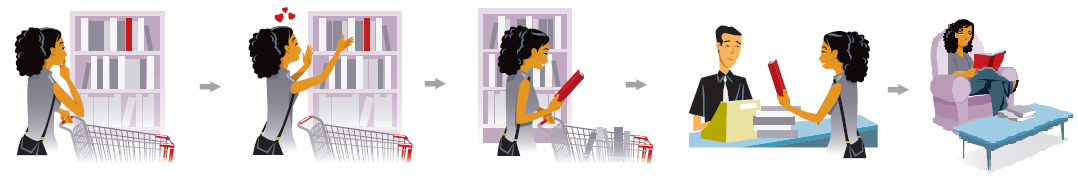

Source : Kim Falk. *Practical Recommender Systems*. 2019. Manning.
    


La réponse à ces questions touche maintenant au cœur des  systèmes recommandés. Votre comportement n'était probablement pas aléatoire, mais avait plutôt une certaine structure et une certaine logique. Vous avez également probablement des préférences particulières pour certains genres et/ou auteurs. Sans même rien savoir d'autre sur les livres, il s'ensuit que les livres que vous avez regardés et achetés correspondaient à ces préférences et que ceux que vous avez ignorés ne correspondaient probablement pas. De plus, en fonction de vos préférences, de ce qui a retenu votre attention et de ce que vous avez déjà lu, la vendeuse a pu reconstituer un profil approximatif de vous. Elle a ensuite pensé à ses précédents clients qui vous ressemblaient et à ce qu'ils avaient acheté auparavant. C'est ainsi qu'elle a pu ensuite présélectionner des livres pertinents à vous proposer.

Comme vous l'avez probablement deviné, la vendeuse est le  système recommandé dans cet exemple. Mais au lieu d'une personne, nous voulons construire quelque chose qui soit capable d'apprendre la structure latente entre tous les livres, tous nos clients, et la façon dont ils correspondent les uns aux autres afin de faire ensuite nos recommandations. Dans les sections suivantes, nous allons apprendre à le faire. Mais tout d'abord, examinons l'architecture générale d'un recommender system.


### **1.2 Architecture d'un système de recommandation**

#### **1.2.1 Vue d'ensemble**


    


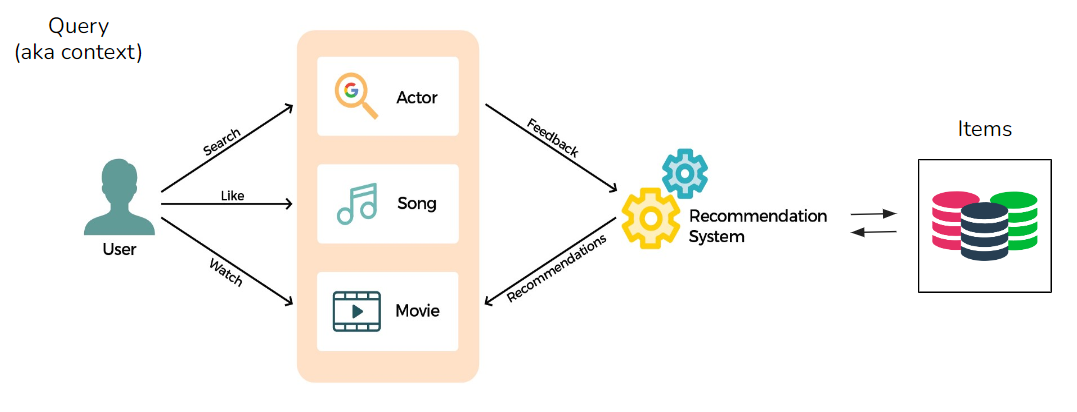

Source: [*Recommendation System Design*](https://medium.com/double-pointer/system-design-interview-recommendation-system-design-as-used-by-youtube-netflix-etc-c457aaec3ab). 2021. Medium.

Le schéma ci-dessus généralise notre scénario précédent des livres aux recherches, chansons et films (notez qu'il n'y en aura généralement qu'un seul), tandis que l'utilisateur est vous, comme précédemment. Remarquez comment l'utilisateur interagit avec ces *articles* qui sont ensuite envoyés au système de recommandation en guise de retour d'information. Le système de recommandation traite cela, récupère les articles pertinents de sa base de données et les sert ensuite à l'utilisateur. L'utilisateur, à son tour, interagit davantage avec ces articles et poursuit cette boucle jusqu'à ce que certains critères d'arrêt soient remplis. Peut-être ont-ils trouvé un film qu'ils aiment et ont commencé à le regarder, ou ils achètent un livre comme dans notre exemple précédent, ou ils partent simplement.

Enfin, vous avez peut-être remarqué une nouvelle terminologie dans le schéma, la *requête / le contexte* du côté utilisateur du schéma. Il s'agit d'une généralisation supplémentaire de ce pour quoi nous récupérons des éléments pertinents. Dans cet exemple, il s'agit de l'utilisateur, mais cela peut également inclure ses recherches précédentes, ses interactions avec les articles, l'heure de la journée, l'appareil qu'il utilise ou toute combinaison de ceux-ci.

#### **1.2.2 Zoom avant**

Rapprochons-nous maintenant du système de recommandation en regardant comment YouTube a décrit le sien en 2016 dans son article fondateur sur le sujet. S'agissant de YouTube, ici les articles  seraient des vidéos qui se comptent en millions (et très probablement en milliards à l'heure où nous écrivons ces lignes en 2023). Portez une attention particulière aux étapes bleues, remarquez le nombre d'articles entrant dans chaque étape qui diminue et donc la forme d'entonnoir.

En regardant la première, le travail de l'étape de *génération de candidats* est de *récupérer* efficacement les articles pertinents de votre base de données (c'est pourquoi vous pouvez trouver dans la littérature, cette étape est également connue sous le nom de *recherche*). La vitesse est ici primordiale, de sorte qu'une certaine marge de manœuvre est autorisée en termes de pertinence, tant que le nombre d'articles que nous réduisons est gérable pour les parties en aval du système de recommandation. Cette vitesse de recherche est obtenue en partie grâce aux techniques que nous aborderons et mettrons en œuvre plus loin dans ce cours pratique, mais aussi en limitant le nombre de caractéristiques qui alimentent cette étape.

La deuxième étape de *classement* (également appelée *notation*) prend ensuite ces articles et les classe en fonction de caractéristiques supplémentaires provenant de l'utilisateur ainsi que des caractéristiques de l'article lui-même afin d'optimiser une cible qui nous intéresse. Dans le cas de YouTube, ce sera le temps de visionnage, ou dans le cas d'un site web de commerce électronique, la probabilité d'acheter les articles. Une autre raison d'avoir une étape de classement est que vous pouvez avoir plusieurs générateurs de candidats et que vous avez maintenant besoin d'un moyen de combiner les résultats d'une manière optimale, à quel point ils sont ensuite présentés à l'utilisateur. Il est également important de noter que cette étape de classement n'est pas toujours nécessaire. Parfois, l'étape de récupération est suffisamment bonne et vous pouvez réduire la complexité du système, les temps de mise en œuvre, les frais de maintenance et donc les coûts.


    



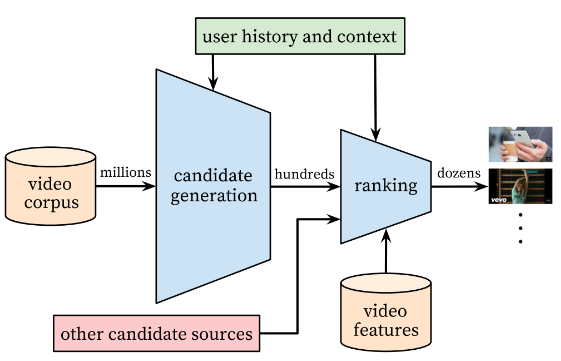

Source: Covington et. al. [*Deep Neural Networks for YouTube Recommendations*](https://research.google/pubs/pub45530/). 2016. Proceedings of the 10th ACM Conference on Recommender Systems.

Enfin, ce dernier schéma, gracieuseté de l'équipe de recommandation de NVIDIA, développe les idées ci-dessus en définissant deux étapes supplémentaires, à savoir le *filtrage* et le *classement*. Après l'étape de recherche / génération de candidats, nous pouvons constater que certains articles, bien que pertinents, ne sont pas utiles et doivent donc être filtrés. Dans un scénario de commerce électronique, il peut s'agir d'un article en rupture de stock ou, dans le cas d'une plateforme de médias sociaux, d'un message provenant d'une personne ou d'un sujet que vous avez bloqué/masqué. L'étape de *classement*, qui a lieu après le classement / la notation, consiste alors à affiner l'ordre des articles en fonction d'une certaine logique métier. Par exemple, la promotion d'articles en solde ou même des placements sponsorisés.


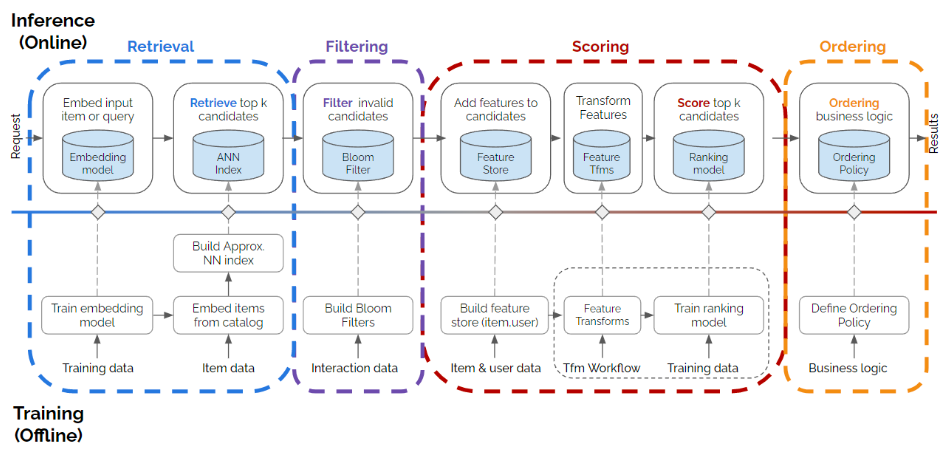

Source: Even Oldridge. [*Recommender Systems, Not Just Recommender Models*](https://medium.com/nvidia-merlin/recommender-systems-not-just-recommender-models-485c161c755e). 2022. Medium.

Le reste de cet atelier pratique se concentrera désormais principalement sur l'étape de recherche / génération de candidats d'un système de recommandation. Nous espérons que cette introduction et cette vue d'ensemble des systèmes de recommandation aideront à mettre en contexte l'élément spécifique que nous allons développer. En particulier, nous allons nous intéresser au filtrage collaboratif (Collaborative Filtering) et aux réseaux neuronaux graphiques (Graph Neural Networks) pour les recommandations.


## **2. Filtrage collaboratif (Collaborative Filtering)**

### **2.1 Aperçu**

Le filtrage collaboratif (Collaborative Filtering) est une technique qui apprend à recommander des articles à l'utilisateur A en fonction des intérêts d'un utilisateur B similaire en utilisant simultanément les similitudes entre ces utilisateurs et ces articles. Cela s'oppose au filtrage basé sur le contenu qui utilise des caractéristiques d'un article créées manuellement et/ou explicites pour d'autres recommandations, par exemple, recommander un film du même genre que celui que vous avez déjà regardé.


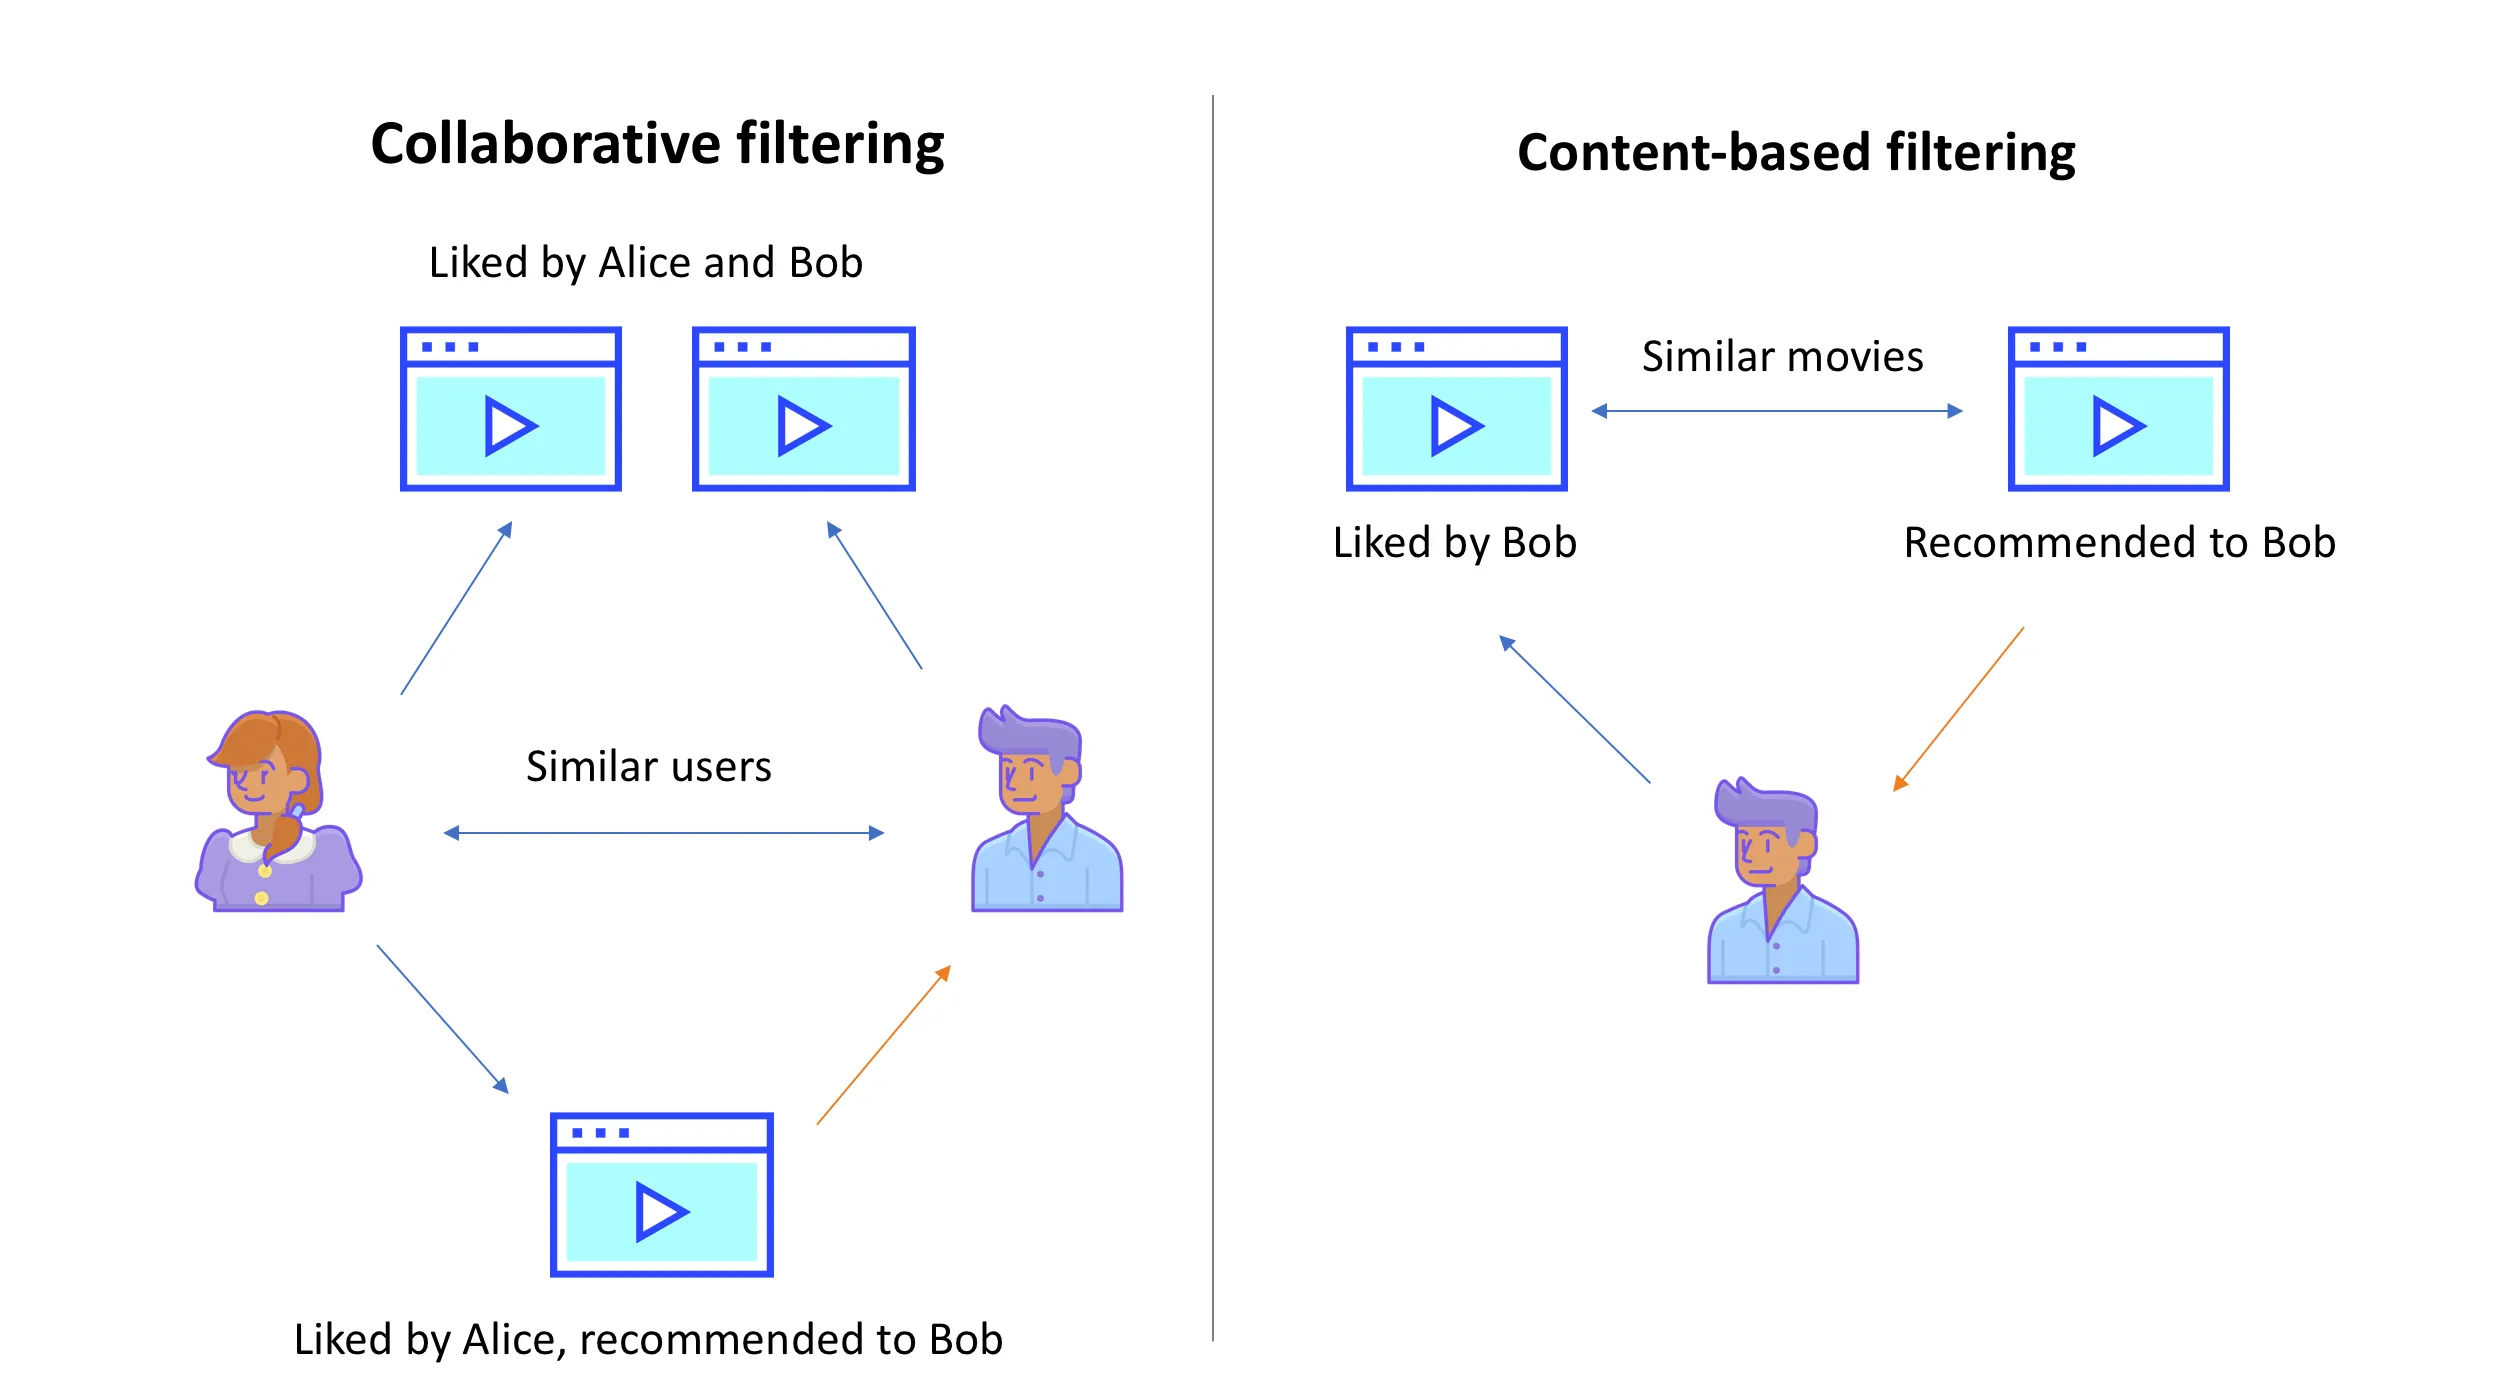

    
Source: Arthur Mello. [*How do Netflix and Amazon know what I want?*](https://towardsdatascience.com/how-do-netflix-and-amazon-know-what-i-want-852c480b67ac). 2020. Medium.

### **2.2 Factorisation matricielle (Matrix Factorisation)**

Considérons un système de recommandation de films dans lequel les données d'apprentissage sont constituées d'une matrice de rétroaction $A ∈ R^{m × n}$ où $m$ est le nombre d'utilisateurs et $n$ le nombre d'articles. Chaque ligne représente alors un utilisateur et chaque colonne un article (un film), les entrées indiquant la note attribuée par un utilisateur à un film particulier. Notre objectif est alors d'apprendre
- Une matrice de plongement utilisateur (user embedding) $U ∈ \mathbb{R}^{m × d}$, où la ligne $i$ est le plongement pour l'utilisateur $i$ et $d$ est la longueur du plongement.
- Une matrice de plongement d'articles (item embedding) $V ∈ \mathbb{R}^{n × d}$, où la ligne $j$ est le plongement pour l'article $j$ et $d$ est la longueur du plongement.

de telle sorte que leur produit $UV^{T}$ soit une bonne approximation de la matrice de rétroaction $A$. Notez que l'entrée $(i, j)$ de $UV^{T}$ est simplement le produit scalaire de $⟨ U_i, V_j ⟩$ des plongements de l'utilisateur $i$ et de l'article $j$ que vous voulez être aussi proche que possible de $A_{ij}$. Ce processus de recherche de ces matrices $U$ et $V$ est connu sous le nom de *factorisation matricielle (matrix factorisation)*.


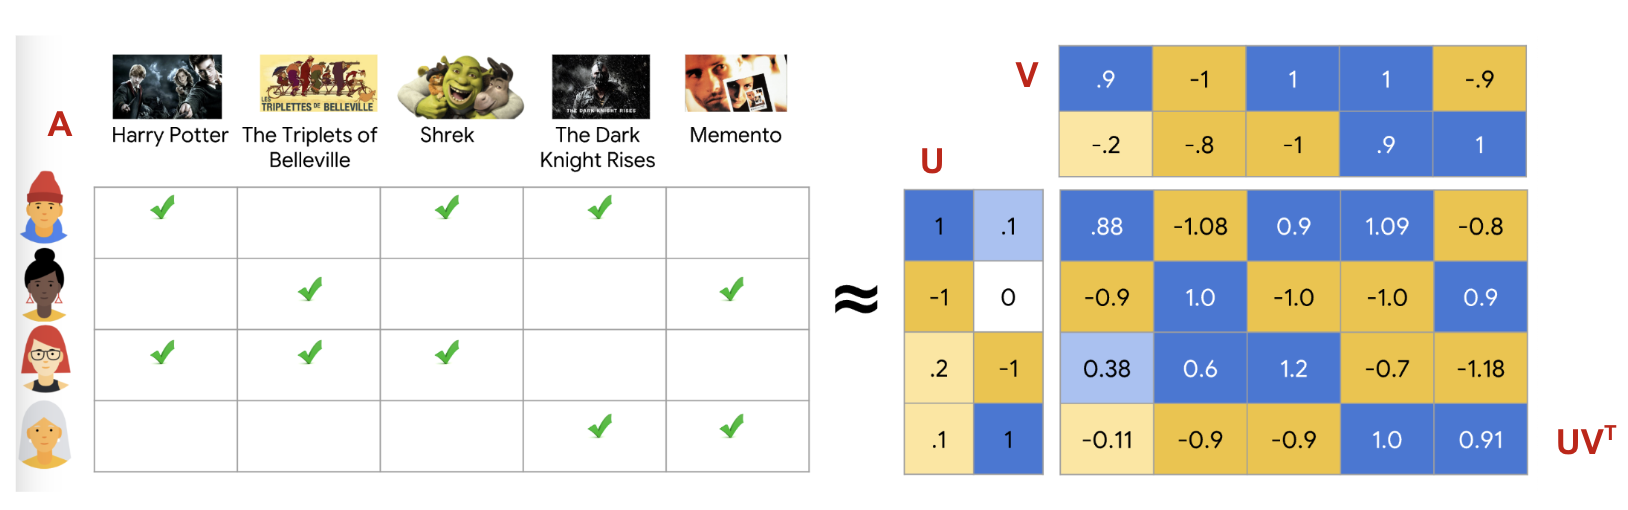

Source: [*Google Recommendation Systems Course*](https://developers.google.com/machine-learning/recommendation/collaborative/matrix).

Notez en particulier comment les matrices $U$ et $V$ donnent une représentation plus compacte de la matrice complète, même dans cet exemple jouet (en pratique, $d$ est beaucoup plus petit que $m$ et $n$ puisque vous aurez beaucoup plus d'utilisateurs et d'articles). Par conséquent, ce processus trouve une structure latente dans les données sans même nécessiter de connaissance des films eux-mêmes !

Maintenant, il existe deux algorithmes courants pour trouver ces matrices, à savoir :
- La Descente de gradient stochastique (Stochastic Gradient Descent - SGD) qui est une méthode générique pour minimiser les fonctions de perte
- La méthode des moindres carrés alternés pondérés (Weighted Alternating Least Squares - WALS) qui est spécialisée pour ce problème particulier et qui fonctionne en alternant entre la fixation de $U$ et la résolution pour $V$ et vice versa.

Pour ce TP, nous allons utiliser SGD pour apprendre ces matrices, ce qui signifie que nous devons définir une fonction de perte. Une fonction intuitive est la distance au carré. Pour ce faire, nous minimisons la moyenne des erreurs quadratiques sur toutes les paires d'entrées observées.

$ \frac{1}{|obs|} ∑_{(i,j) \in obs} (A_{ij} - ⟨ U_i, V_j ⟩)^2$

Avec cette fonction de perte définie, nous pouvons alors initialiser aléatoirement nos matrices $U$ et $V$, et par SGD les mettre à jour itérativement jusqu'à ce que $UV^T$ soit une bonne approximation de $A$. Nous avons maintenant enfin tous les éléments pour avancer dans la suite du tutoriel.

### **2.3 Le jeu de données MovieLens (The MovieLens Dataset)**

Puisque nous n'avons pas accès à l'historique de visionnage d'un véritable service de streaming, nous allons plutôt utiliser un jeu de données appelé [MovieLens](https://grouplens.org/datasets/movielens/) et en particulier le sous-ensemble `latest-small-ratings` qui contient 100 000 évaluations pour 9 000 films et 600 utilisateurs. Jetons-y un coup d'œil.


In [ ]:
mld = MovieLensDataset("ml-latest-small")
df, movies = mld.to_pandas()
movie_lookup = make_movie_lookup(df)
# (user_id: ID utilisateur, movie_title: titre du film, user_rating: note utilisateur)
df.sample(5)[['user_id', 'movie_title', 'user_rating', 'timestamp']]



Comme vous pouvez le constater, nous avons nos utilisateurs représentés par l'`user_id`, les films (nos articles) et la  `user_rating` (note utilisateur) sur 5 que l'utilisateur a attribuée à ce film en particulier. Nous avons également le `timestamp` (horodatage) du moment où l'utilisateur a noté le film au format temps unix, qui correspond au nombre de secondes écoulées depuis le 1er janvier 1970 UTC et constitue un moyen courant de représenter le temps en raison de son absence d'ambiguïté.

Voyons maintenant ce qui se passe si nous croisons un échantillon de ces données pour obtenir une vue alternative.
    


In [ ]:
cross_tabulate(df)


Le tableau affiché montre quelques-uns des films et des utilisateurs les plus populaires. Les cellules vides sont celles que nous voulons que notre modèle apprenne à remplir, c'est-à-dire les films que nous supposons qu'un utilisateur n'a pas encore regardés parce qu'il ne les a pas encore notés. Ensuite, une fois que nous aurons fait ces prédictions, nous pourrons déterminer lesquels de ces films sont les plus susceptibles de leur plaire.

En regardant ce tableau, vous avez peut-être également remarqué sa faible densité. En réalité, ce tableau l'est encore plus. Calculons combien de cellules sont vides.
    


In [ ]:
num_users = df['user_id'].unique().shape[0]
num_items = df['movie_title'].unique().shape[0]
num_ratings = df.shape[0]
sparsity = 100 - (num_ratings / (num_users * num_items) * 100)
print(f"Sparsity: {sparsity:.2f}")


### **2.2 Préparation du jeu de données**

Maintenant, préparons notre jeu de données pour l'entraînement. Nous allons mapper nos utilisateurs et nos films à partir d'index commençant à 0.


In [ ]:
df['user_id'], user_list, user_to_id_mapping = densify_column_values(df, 'user_id')
df['item_id'], movie_list, movie_to_id_mapping = densify_column_values(df, 'movie_title')
df.head(5)[['user_id', 'item_id', 'user_rating', 'timestamp']] #(user_rating = note utilisateur)



Ensuite, nous allons diviser aléatoirement nos données en un ensemble d'entraînement et de validation et créer nos dataloaders qui alimenteront notre processus d'entraînement plus tard. Les détails exacts ne sont pas très importants ici, mais si vous êtes intéressé, n'hésitez pas à inspecter ces méthodes dans la cellule Méthodes d'aide en haut de ce notebook.


In [ ]:
train_df, val_df = get_train_val_split(df)
train_ds, val_ds = prepare_dataloaders(train_df, val_df, config.BATCH_SIZE, config.NUM_EPOCHS)
total_steps = train_ds.cardinality().numpy()



Nous sommes maintenant prêts à enfin commencer l'implémentation de notre modèle de filtrage collaboratif.


### **2.3 Construction de notre modèle**


#### **2.3.1 Modèle de produit scalaire (Tâche)**

Commençons par définir l'architecture de ce modèle dans sa formulation la plus simple. Implémentez les étapes ci-dessous dans la cellule de code ci-dessous.
1. Définissez $m$ et $n$ qui correspondent respectivement au nombre d'utilisateurs et d'articles.
2. Définissez $d$ correspondant à la dimension des matrices d'embedding ci-dessous.
3. Créez et spécifiez la forme de nos matrices d'embedding. Rappelez-vous que $U ∈ \mathbb{R}^{m × d}$ et $V ∈ \mathbb{R}^{n × d}$ pour les embeddings des utilisateurs et des articles, respectivement. Indice : [`nn.Embed`](https://flax.readthedocs.io/en/latest/api_reference/flax.linen/_autosummary/flax.linen.Embed.html)
4. Prenez le produit scalaire des embeddings utilisateur et article, respectivement. Indice : [`jnp.multiply`](https://jax.readthedocs.io/en/latest/_autosummary/jax.numpy.multiply.html) et [`jnp.sum`](https://jax.readthedocs.io/en/latest/_autosummary/jax.numpy.sum.html) peuvent être utiles ici.


In [ ]:
class CFDotProduct(nn.Module):
  # Étape 1 et 2
  # définir le nombre d'utilisateurs (correspond à m)
  # définir le nombre d'articles (correspond à n)
  # définir la dimension de l'embedding ici (correspond à d)

  @nn.compact
  def __call__(self, x):
    # Étape 3 Spécifiez la forme des matrices d'embedding
    # (users = utilisateurs, items = articles)
    users = nn.Embed(num_embeddings=? features=?, name='user_embs')(x['user_id'])
    items = nn.Embed(num_embeddings=? features=?, name='item_embs')(x['item_id'])

    y = # Étape 4 prendre le produit scalaire des utilisateurs et des articles
    return y


Révélez la cellule ci-dessous pour voir la solution
    


In [ ]:
# @title Solution
class CFDotProduct(nn.Module):
  #nombre d'utilisateurs: num_users
  num_users: int
  #nombre d'articles: num_items
  num_items: int
  #dimension d'embedding: emb_dim
  emb_dim: int

  @nn.compact
  def __call__(self, x):
    users = nn.Embed(num_embeddings=self.num_users, features=self.emb_dim, embedding_init=nn.initializers.normal(), name='user_embs')(x['user_id'])
    items = nn.Embed(num_embeddings=self.num_items, features=self.emb_dim, embedding_init=nn.initializers.normal(), name='item_embs')(x['item_id'])

    y = jnp.sum(jnp.multiply(users, items), axis=1)
    return y



Maintenant que nous avons spécifié la forme du modèle, nous devons définir notre fonction de perte (loss). Rappelez-vous qu'il s'agira de l'erreur quadratique moyenne entre nos évaluations prédites et les évaluations réelles. Étant donné que cette perte est également une mesure raisonnable pour mesurer la performance de notre modèle, nous l'utiliserons également. Indice : [`optax.squared_error`](https://optax.readthedocs.io/en/latest/api.html#optax.squared_error).


In [ ]:
@jax.jit
def train_step(state, batch):
  def loss_fn(params):
    logits = state.apply_fn(params, batch)
    loss = # complétez la fonction de perte ici et calculez ensuite la moyenne de notre lot (batch)
    return loss
  grad_fn = jax.grad(loss_fn)
  grads = grad_fn(state.params)
  state = state.apply_gradients(grads=grads)
  return state

@jax.jit
def compute_metrics(*, state, batch):
  logits = state.apply_fn(state.params, batch)
  loss =  # complétez la fonction de perte ici et calculez ensuite la moyenne de notre lot (batch)
  metric_updates = state.metrics.single_from_model_output(logits=logits, labels=batch['user_rating'], loss=loss)
  metrics = state.metrics.merge(metric_updates)
  state = state.replace(metrics=metrics)
  return state



Révélez la cellule ci-dessous pour voir la solution
    



In [ ]:
# @title Solution
@jax.jit
def train_step(state, batch):
  def loss_fn(params):
    logits = state.apply_fn(params, batch)
    loss = optax.squared_error(logits, batch['user_rating']).mean()
    return loss
  grad_fn = jax.grad(loss_fn)
  grads = grad_fn(state.params)
  state = state.apply_gradients(grads=grads)
  return state

@jax.jit
def compute_metrics(*, state, batch):
  logits = state.apply_fn(state.params, batch)
  loss = optax.squared_error(logits, batch['user_rating']).mean()
  # (logits, labels)
  metric_updates = state.metrics.single_from_model_output(logits=logits, labels=batch['user_rating'], loss=loss)
  metrics = state.metrics.merge(metric_updates)
  state = state.replace(metrics=metrics)
  return state



Maintenant que nous avons défini nos fonctions de modèle et de perte, initialisons notre état d'entraînement et définissons notre boucle d'entraînement.


In [ ]:
@struct.dataclass
class Metrics(metrics.Collection):
    loss: metrics.Average.from_output('loss')

class TrainState(train_state.TrainState):
    metrics: Metrics

# (params = paramètres)
def initialise_train_state(model, model_rng, dataloader, total_steps, weight_decay=None):
  params = model.init(model_rng, next(tfds.as_numpy(dataloader).__iter__()))
  scheduler = optax.cosine_onecycle_schedule(
    transition_steps=total_steps,
    peak_value=config.LR,
    pct_start=0.25,
    div_factor=25.0,
    final_div_factor=100000.0
  )

  if weight_decay:
    tx = optax.adamw(learning_rate=scheduler, weight_decay=weight_decay)
  else:
    tx = optax.adam(learning_rate=scheduler)

  state = TrainState.create(
    apply_fn=model.apply,
    params=params,
    tx=tx,
    metrics=Metrics.empty()
  )
  return state

# (train_ds = données d'entraînement, val_ds = données de validation)
def train_model(state, train_ds, val_ds):
  num_steps_per_epoch = train_ds.cardinality().numpy() // config.NUM_EPOCHS

  metrics_history = {
    'train_loss': [],
    'val_loss': [],
  }

  for step, batch in enumerate(train_ds.as_numpy_iterator()):
    state = train_step(state, batch)
    state = compute_metrics(state=state, batch=batch)

    if (step+1) % num_steps_per_epoch == 0:
      for metric, value in state.metrics.compute().items():
          metrics_history[f'train_{metric}'].append(value)
      state = state.replace(metrics=state.metrics.empty())

      val_state = state
      for val_batch in val_ds.as_numpy_iterator():
          val_state = compute_metrics(state=val_state, batch=val_batch)

      for metric, value in val_state.metrics.compute().items():
          metrics_history[f'val_{metric}'].append(value)

      print(
          f"train epoch: {(step+1) // num_steps_per_epoch}, " # (epoch = époque)
          f"loss: {metrics_history['train_loss'][-1]}, " # (loss = perte)
      )
      print(
          f"val epoch: {(step+1) // num_steps_per_epoch}, " # (epoch = époque)
          f"loss: {metrics_history['val_loss'][-1]}, " # (loss = perte)
      )

  return state, metrics_history




Nous sommes maintenant prêts à entraîner notre modèle !


In [ ]:
model = CFDotProduct(num_users=len(user_list), num_items=len(movie_list), emb_dim=config.EMB_DIM)
state = initialise_train_state(model, model_rng, train_ds, total_steps)
state, metric_history = train_model(state, train_ds, val_ds)
plot_metric_history(metric_history)


Étant donné que nos évaluations sont comprises entre `0.5` et `5`, la première chose que nous pouvons faire pour améliorer un peu ce modèle est de forcer les prédictions à se situer dans cette plage. Une fonction utile pour cela serait la fonction [`sigmoid`](https://flax.readthedocs.io/en/v0.5.3/_autosummary/flax.linen.sigmoid.html) qui contraint son entrée entre `0` et `1`. Multiplier et décaler cette valeur nous permet ensuite de déplacer ces valeurs vers n'importe quelle plage de valeurs. Choisissons `0` et `5.5` car, empiriquement, ces valeurs fonctionnent mieux en élargissant la plage des valeurs autorisées.


In [ ]:

    class CFWithRange(nn.Module):
      num_users: int
      num_items: int
      emb_dim: int
      # définit l'évaluation minimale (min_rating)
      # définit l'évaluation maximale (max_rating)

      @nn.compact
      def __call__(self, x):
        user_embeds = nn.Embed(num_embeddings=self.num_users, features=self.emb_dim, embedding_init=nn.initializers.normal(), name='user_embs')(x['user_id'])
        item_embeds = nn.Embed(num_embeddings=self.num_items, features=self.emb_dim, embedding_init=nn.initializers.normal(), name='item_embs')(x['item_id'])

        y = jnp.sum(jnp.multiply(user_embeds, item_embeds), axis=1)
        y = # contraindre y entre 0 et 1
        y = # étendre la plage entre 0 et 5,5.
        return y



In [ ]:
# @title Solution
class CFWithRange(nn.Module):
  num_users: int
  num_items: int
  emb_dim: int
  min_rating: float
  max_rating: float

  @nn.compact
  def __call__(self, x):
    user_embeds = nn.Embed(num_embeddings=self.num_users, features=self.emb_dim, embedding_init=nn.initializers.uniform(), name='user_embs')(x['user_id'])
    item_embeds = nn.Embed(num_embeddings=self.num_items, features=self.emb_dim, embedding_init=nn.initializers.uniform(), name='item_embs')(x['item_id'])

    y = jnp.sum(jnp.multiply(user_embeds, item_embeds), axis=1)
    y = nn.sigmoid(y) # Applique la fonction sigmoïde pour contraindre la sortie entre 0 et 1
    y = y * (self.max_rating - self.min_rating) + self.min_rating #  étend la plage de y pour correspondre à la plage d'évaluation (min_rating, max_rating)
    return y




Nous sommes maintenant prêts à entraîner à nouveau le modèle. Voyons voir ce que ça donne.
    



In [ ]:
model = CFWithRange(
  num_users=len(user_list), # nombre d'utilisateurs
  num_items=len(movie_list), # nombre de films
  emb_dim=config.EMB_DIM,
  min_rating=0,
  max_rating=5.5
)
state = initialise_train_state(model, model_rng, train_ds, total_steps)
state, metric_history = train_model(state, train_ds, val_ds)
plot_metric_history(metric_history) # historique des métriques




Si tout s'est bien passé, cela aurait dû donner un peu mieux. Il manque maintenant un élément : certains utilisateurs sont simplement plus positifs ou négatifs dans leurs évaluations que d'autres, et certains films sont tout simplement meilleurs ou pires que d'autres. Mais dans notre représentation par produit scalaire, nous n'avons aucun moyen d'encoder l'une ou l'autre de ces choses. Si tout ce que vous pouvez dire d'un film est, par exemple, qu'il est très science-fiction ou très orienté vers l'action, alors vous n'avez pas vraiment la possibilité de dire si la plupart des gens l'aiment.

C'est parce qu'à ce stade, nous n'avons que des poids (weights), nous n'avons pas de biais (biases). Si nous avons un seul nombre pour chaque utilisateur que nous pouvons ajouter à nos scores, et la même chose pour chaque film, cela permettra de gérer cet élément manquant. Modifions à nouveau l'architecture de notre modèle.


#### **2.3.2 Modèle de produit scalaire avec biais (Dot Product with Bias Model) (Tâche)**

Pour chaque utilisateur et pour chaque article, nous ajoutons un seul chiffre. Cela correspond à des représentations ou incorporations  unidimensionnelles, chacune de la longueur du nombre d'utilisateurs et du nombre d'articles respectivement.Ajoutons-les ci-dessous.
    


In [ ]:
class CFDotProductBias(nn.Module):
  num_items: int  # nombre d'éléments
  num_users: int  # nombre d'utilisateurs
  emb_dim: int
  min_rating: float
  max_rating: float

  @nn.compact
  def __call__(self, x):
    user_embeds = nn.Embed(num_embeddings=self.num_users, features=self.emb_dim, embedding_init=nn.initializers.normal(), name='user_embs')(x['user_id'])
    item_embeds = nn.Embed(num_embeddings=self.num_items, features=self.emb_dim, embedding_init=nn.initializers.normal(), name='item_embs')(x['item_id'])
    # Ajouter les termes de biais unidimensionnels ici (biais utilisateur: user_bias, biais élément: item_bias)
    user_bias = nn.Embed(num_embeddings=?, features=?, embedding_init=nn.initializers.normal(), name='user_bias')(x['user_id'])
    item_bias = nn.Embed(num_embeddings=?, features=?, embedding_init=nn.initializers.normal(), name='item_bias')(x['item_id'])

    y = jnp.sum(jnp.multiply(user_embeds, item_embeds), axis=1, keepdims=1)
    y += # ajouter les biais
    y = nn.sigmoid(y) * (self.max_rating - self.min_rating) + self.min_rating
    return jnp.squeeze(y)


Révélez la cellule ci-dessous pour voir la solution
    


In [ ]:
# @title Solution
class CFDotProductBias(nn.Module):
  num_items: int  # nombre d'éléments
  num_users: int  # nombre d'utilisateurs
  emb_dim: int
  min_rating: float
  max_rating: float

  @nn.compact
  def __call__(self, x):
    item_embeds = nn.Embed(num_embeddings=self.num_items, features=self.emb_dim, embedding_init=nn.initializers.normal(), name='item_embs')(x['item_id'])  # embeddings des éléments (item_embeds)
    item_bias = nn.Embed(num_embeddings=self.num_items, features=1, embedding_init=nn.initializers.normal(), name='item_bias')(x['item_id'])  # biais des éléments (item_bias)
    user_embeds = nn.Embed(num_embeddings=self.num_users, features=self.emb_dim, embedding_init=nn.initializers.normal(), name='user_embs')(x['user_id'])  # embeddings des utilisateurs (user_embeds)
    user_bias = nn.Embed(num_embeddings=self.num_users, features=1, embedding_init=nn.initializers.normal(), name='user_bias')(x['user_id'])  # biais des utilisateurs (user_bias)

    y = jnp.sum(jnp.multiply(user_embeds, item_embeds), axis=1, keepdims=1)
    y += user_bias + item_bias
    y = nn.sigmoid(y) * (self.max_rating - self.min_rating) + self.min_rating
    return jnp.squeeze(y)




Entraînons notre modèle et voyons comment celui-ci fonctionne.


In [ ]:
model = CFDotProductBias(
  num_items=len(movie_list), # nombre d'items (films)
  num_users=len(user_list),  # nombre d'utilisateurs
  emb_dim=config.EMB_DIM,
  min_rating=0.0,
  max_rating=5.5
)
state = initialise_train_state(model, model_rng, train_ds, total_steps)
state, metric_history = train_model(state, train_ds, val_ds)
plot_metric_history(metric_history)


##### **2.3.2.1 Atténuer le surapprentissage**

Il semble que notre modèle ait commencé à surapprendre puisque notre perte de validation a commencé à augmenter tandis que notre perte d'entraînement a continué à diminuer. Une façon d'atténuer cela est de contraindre notre modèle avec une régularisation de type weight decay. Les détails ne sont pas importants pour le moment, mais l'idée principale est que cette technique empêche nos poids de devenir trop élevés, un symptôme de surapprentissage. Heureusement cette fois, nous n'avons même pas besoin de changer notre modèle, nous pouvons le spécifier comme un paramètre dans notre étape d'initialisation de l'état (state) et les détails sont pris en charge pour vous. Essayons d'entraîner notre modèle à nouveau.


In [ ]:

# (movie_list): liste de films,  (user_list): liste d'utilisateurs
model = CFDotProductBias(
  num_items=len(movie_list),
  num_users=len(user_list),
  emb_dim=config.EMB_DIM,
  min_rating=0.0,
  max_rating=5.5
)
# (state): état, (weight_decay): atténuation du poids
state = initialise_train_state(model, model_rng, train_ds, total_steps, weight_decay=0.1)
# (metric_history): historique des métriques
state, metric_history = train_model(state, train_ds, val_ds)
plot_metric_history(metric_history)
```


Super, cela aurait dû améliorer le modèle et stabiliser notre perte de validation. Essayons maintenant d'interpréter le modèle que nous venons de construire.


### **2.4 Interprétation de notre modèle**

#### **2.4.1 Biais**

Nous avons mentionné précédemment que les biais que nous avons ajoutés au modèle pourraient coder si certains utilisateurs sont généralement plus positifs ou négatifs dans leurs évaluations et si certains films sont universellement meilleurs ou pires que d'autres. Mettons cela à l'épreuve en inspectant les biais. Nous allons d'abord examiner les pires films, c'est-à-dire les films avec les biais les plus faibles
    
    


In [ ]:
item_movie_df = df.drop_duplicates(subset='movie_id')[['item_id', 'movie_id']]
item_id_to_movie_id_mapping = dict(zip(item_movie_df.item_id, item_movie_df.movie_id))

id_to_movie_mapping = {}
for movie, id in movie_to_id_mapping.items():
    id_to_movie_mapping[id] = movie

# item_ids (fr: identifiants d'éléments)
def display_recommendations(item_ids: list[int]):
    if config.USE_POSTERS:
        # movie_ids (fr: identifiants de films)
        movie_ids = [item_id_to_movie_id_mapping[item_id] for item_id in item_ids]
        fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(20, 7), dpi=80, sharex=True, sharey=True)
        for i, movie_id in enumerate(movie_ids):
            poster_path = f'./recsys_data/posters/{movie_id}.jpg'
            if not os.path.isfile(poster_path):
                poster_path = f'./recsys_data/posters/default.jpg'
            image = plt.imread(poster_path)
            ax[i].imshow(image)
            ax[i].axis('off')
            ax[i].set_title("\n".join(wrap(movie_lookup[movie_id], 35)))
    else:
        for item_id in item_ids:
            print(id_to_movie_mapping[item_id])




In [ ]:
item_ids = state.params['params']['item_bias']['embedding'].squeeze().argsort().tolist()[:5]
display_recommendations(item_ids)



Espérons qu'aucun de ces films ne fait partie de vos préférés !

Voyons maintenant ce que le modèle a appris à considérer comme étant parmi les meilleurs films.


In [ ]:
item_ids = state.params['params']['item_bias']['embedding'].squeeze().argsort().tolist()[-5:]
display_recommendations(item_ids)



Reconnaissez-vous certains de ces films et, si oui, êtes-vous d'accord avec le modèle pour dire que ces films sont généralement appréciés de tous ? Si vous n'en avez regardé aucun, vous pouvez peut-être en choisir un la prochaine fois que vous chercherez quelque chose à regarder et mettre ce modèle à l'épreuve !


#### **2.4.2 distance d'incorporation **

Nosincorporations ne sont pas si faciles à interpréter directement, car il y a trop de facteurs à prendre en compte. Nous pouvons cependant mesurer la similarité entre eux. Plus formellement, une mesure de similarité est une fonction $s : E × E → \mathbb{R}$ qui prend une paire d'incorporations et retourne un scalaire mesurant leur similarité. Les incorporations peuvent être utilisés pour la génération de candidats comme suit : étant donné une incorporation de requête $q \in E$, le système recherche des incorporations d'items $x \in E$ qui sont proches de q, c'est-à-dire desincorporations ayant une forte similarité $s(q,x)$. Pour déterminer la similarité, la plupart des systèmes de recommandation s'appuient sur une ou plusieurs des méthodes suivantes :
 - **Cosinus** : le cosinus de l'angle entre les deux vecteurs $s(q,x) = cos(q,x)$
 - **Produit scalaire** : le produit scalaire des deux vecteurs $s(q,x) = ∑_{i=1}^{d} q_i x_i$
 - **Distance euclidienne** : la distance dans l'espace euclidien, $s(q,x) = ||q - x|| = [∑_{i=1}^{d} (q_i - x_i)^2]^{\frac{1}{2}}$

 Pour les besoins de cet exercice pratique, choisissons la similarité cosinus pour notre système de recommandation. Nous définissons d'abord la fonction qui calculera la similarité cosinus entre l'incorporation de l'item sélectionné et tous les autres incorporations.
    


In [ ]:

    def get_cos_sim_distances(item, embeddings): # get_cos_sim_distances -> obtient les distances de similarité cosinus
      dot_products = jnp.sum(item[None] * embeddings, axis=1) # produit scalaire
      norm_item = jnp.linalg.norm(item) # norme de l'item
      norm_all = jnp.linalg.norm(embeddings, axis=1) # norme de tous les encastrements
      distances = (dot_products / (norm_item * norm_all))
      return distances



Définissons une fonction qui trouvera les films les plus similaires à celui que nous spécifions
    


In [ ]:
def get_top_k_most_similar_movies(movie_name, embeddings, k):
  movie_id = movie_to_id_mapping[movie_name] # obtenir l'ID du film (movie_id)
  distances = get_cos_sim_distances(embeddings[movie_id], embeddings) # calculer les distances entre le film et tous les autres
  # Trier par ordre croissant et prendre les k derniers ID de films (en excluant le film lui-même qui sera le plus similaire, c'est-à-dire angle = 0)
  # Ensuite, inverser l'ordre afin que les ID de films les plus similaires apparaissent en premier
  return list(reversed(distances.argsort()[-k-1:-1].tolist()))



Appelons maintenant cette méthode et essayons-la sur le deuxième film Avengers.


In [ ]:
similar_ids = get_top_k_most_similar_movies("Terminator 2: Judgment Day (1991)", state.params['params']['item_embs']['embedding'], 5)
display_recommendations(similar_ids)


Essayez de tester avec vos propres films. Pour trouver le nom exact d'un film en particulier, voici une petite fonction d'aide que vous pouvez utiliser.


In [ ]:
import ipywidgets as widgets
from IPython.display import display

# Fonction pour rechercher et afficher les résultats
def search_dataframe(search_text):
    # Filtrer DataFrame en fonction de search_text dans la colonne 'movie_title' (titre du film)
    filtered_df = movies[movies['movie_title'].str.contains(search_text, case=False, na=False)]
    # Afficher le DataFrame filtré
    display(filtered_df)

# Créer un widget de saisie de texte
search_input = widgets.Text(
    value='',
    placeholder='Tapez le nom d\'un film...',
    description='Recherche :',
    disabled=False
)

# Créer un widget de sortie pour afficher les résultats
output = widgets.Output()

# Définir une fonction de gestionnaire d'événements pour le widget de saisie de recherche
def on_search_change(change):
    with output:
        output.clear_output()  # Effacer la sortie précédente
        search_text = change['new']
        search_dataframe(search_text)  # Rechercher et afficher les résultats

# Attacher le gestionnaire d'événements au widget de saisie de texte
search_input.observe(on_search_change, names='value')

# Afficher le widget d'entrée et la sortie
display(search_input, output)



On peut également visualiser nos plongements en utilisant l'[Embedding Projector](https://www.tensorflow.org/tensorboard/tensorboard_projector_plugin) de TensorBoard où l'on peut voir où se situent tous nos plongements de films dans cet espace. Chargeons l'outil. En bas à gauche, vous devriez voir des onglets appelés UMAP, t-SNE et PCA. Les détails de ces techniques dépassent le cadre de ce tutoriel, mais leur idée de base est de regrouper nos plongements dans un espace de plus faible dimension que nous pouvons visualiser.

Essayez de cliquer dans les nuages de points pour voir les films similaires autour du point que vous sélectionnez. Vous pouvez également rechercher (puis cliquer sur) des films sur la droite. Vous pouvez également réduire (ou augmenter) le nombre de films mis en évidence en ajustant le paramètre `neighbours` (voisins).


In [ ]:
# @title Lancer Tensorboard Projector (Launch Tensorboard Projector)

import numpy as np
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter("./tensorboard/")
# (id_to_movie_mapping : correspondance_id_film)
writer.add_embedding(np.asarray(state.params['params']['item_embs']['embedding']), metadata=list(id_to_movie_mapping.values()))

%load_ext tensorboard
%tensorboard --logdir ./tensorboard/



### **2.5 Faire des Recommandations**

En plus de trouver des films similaires uniquement en fonction de leur similitude les uns avec les autres, nous pouvons également trouver les films dans le voisinage des utilisateurs, c'est-à-dire les films les plus similaires à un utilisateur. Cela peut sembler surprenant car les utilisateurs et les films sont des entités différentes. Mais une façon de penser à cela est que notre espace d'incorporation est une représentation abstraite commune aux deux dans laquelle nous pouvons mesurer la similarité à l'aide d'une métrique de similarité.


In [ ]:
user_id = df['user_id'].sample(1).iloc[0] # sélection d'un utilisateur aléatoire
item_embs = state.params['params']['item_embs']['embedding'] # récupération de nos embeddings de films entraînés
user_emb = state.params['params']['user_embs']['embedding'][user_id] # récupération de l'embedding de notre utilisateur entraîné
distances = get_cos_sim_distances(user_emb, item_embs) # calcul de la distance entre notre utilisateur et tous les films
already_watched_movie_ids = df[df['user_id'] == user_id]['item_id'].tolist() # récupération de tous les films que l'utilisateur a déjà regardés
rec_count = 0
# Boucle sur les films les plus proches de l'utilisateur qu'il n'a pas encore regardés
recommended_unwatched_ids = []
for id in reversed(distances.argsort().tolist()):
    if id not in already_watched_movie_ids and rec_count < 5:
        recommended_unwatched_ids.append(id)
        rec_count += 1

display_recommendations(recommended_unwatched_ids)


Puisque notre modèle est entraîné pour prédire les notes des films, utilisons-le directement pour prédire les notes qu'un utilisateur particulier donnerait à tous les films et recommander les films qu'il aurait notés le plus haut.


In [ ]:
@jax.jit
def pred_step(state, batch):
  logits = state.apply_fn(state.params, batch)
  return logits

def create_eval_tfds_from_df(df: pd.DataFrame) -> tf.data.Dataset:
  eval_fields = {
      ('item_id', tf.int32),  # ('identifiant_film', tf.int32),
      ('user_id', tf.int32),  # ('identifiant_utilisateur', tf.int32),
  }
  tensor_slices = {
      field: tf.cast(df[field].values, dtype=field_type)
      for field, field_type in eval_fields
  }

  return tf.data.Dataset.from_tensor_slices(tensor_slices)

# préparation de nos données en associant le même identifiant d'utilisateur à tous nos films
all_items = df['item_id'].unique() # (all_items: tous_les_films)
eval_df = pd.DataFrame({'user_id': [user_id] * all_items.shape[0], 'item_id': all_items}) # (user_id: identifiant_utilisateur, item_id: identifiant_film)
eval_ds = create_eval_tfds_from_df(eval_df).batch(eval_df.shape[0], drop_remainder=False)

# faire la prédiction sur ces données qui renvoie les notes
preds = pred_step(state, eval_ds.as_numpy_iterator().next())
eval_df['preds'] = pd.DataFrame(preds) # (preds: predictions)

# Afficher les 10 films les mieux notés que l'utilisateur n'a pas encore regardés
count = 0
highest_rated_ids = [] # (highest_rated_ids: identifiants_films_mieux_notes)
for row in eval_df.sort_values('preds', ascending=False).itertuples(): # (preds: predictions)
  if row.item_id not in already_watched_movie_ids and count < 5: # (item_id: identifiant_film)
    print(f"{row.preds:.2f}", id_to_movie_mapping[row.item_id]) # (preds: predictions)
    highest_rated_ids.append(row.item_id) # (highest_rated_ids: identifiants_films_mieux_notes, item_id: identifiant_film)
    count += 1
  elif count == 5:
    break

if config.USE_POSTERS:
    display_recommendations(highest_rated_ids) # (highest_rated_ids: identifiants_films_mieux_notes)




### **2.6. Recherches de voisins les plus proches approximatives**

Jusqu'à présent, dans cet exercice pratique, nous avons effectué une *recherche exhaustive* pour les films les plus similaires, c'est-à-dire que nous avons calculé la distance entre un film et tous les autres films. Que se passe-t-il si nous avons des millions de films ? Et des millions d'utilisateurs qui se connectent à notre service de streaming pour lequel nous devons effectuer ces calculs ? Cela va en effet devenir très coûteux en termes de temps et de ressources. Nous avons besoin d'un moyen d'effectuer ces calculs beaucoup plus efficacement. C'est là qu'interviennent les *recherches de voisins les plus proches approximatives*. L'idée est d'échanger un faible degré de précision dans notre recherche de similarité contre un gain de performance énorme (d'ordres de grandeur).

Une implémentation de cette idée, initialement développée chez Spotify, est appelée [*Approximate Nearest Neighbours Oh Yeah*](https://github.com/spotify/annoy) (oui, vraiment) ou plus communément connue sous son acronyme, *ANNOY*. L'algorithme fonctionne en divisant récursivement notre espace d'incorporation par des hyperplans aléatoires, où chaque hyperplan est représenté par un nœud dans un arbre, jusqu'à ce qu'il y ait au plus $k$ éléments à chaque nœud feuille. Afin de trouver les voisins les plus proches pour une incorporation spécifique, l'arbre est parcouru en calculant de quel côté de l'hyperplan se trouve le point à chaque nœud, puis en renvoyant les éléments au nœud final. Voir l'image ci-dessous pour avoir une idée de ce à quoi ressemble la division dans un espace 2D et l'arbre résultant.


    



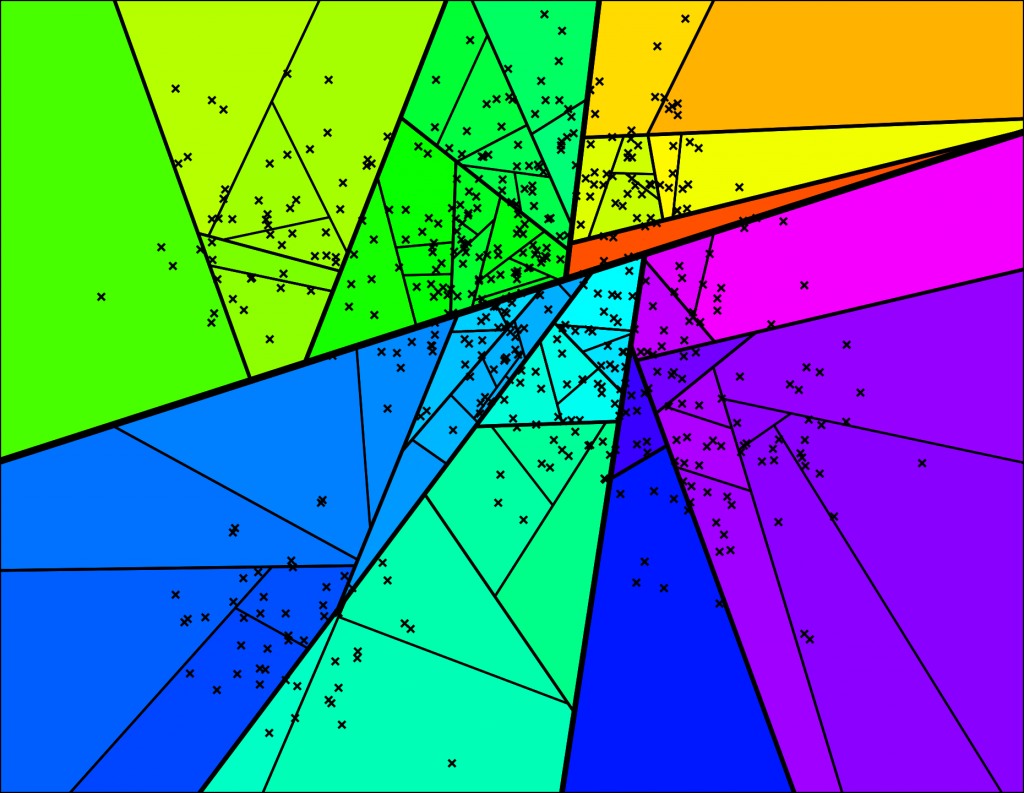

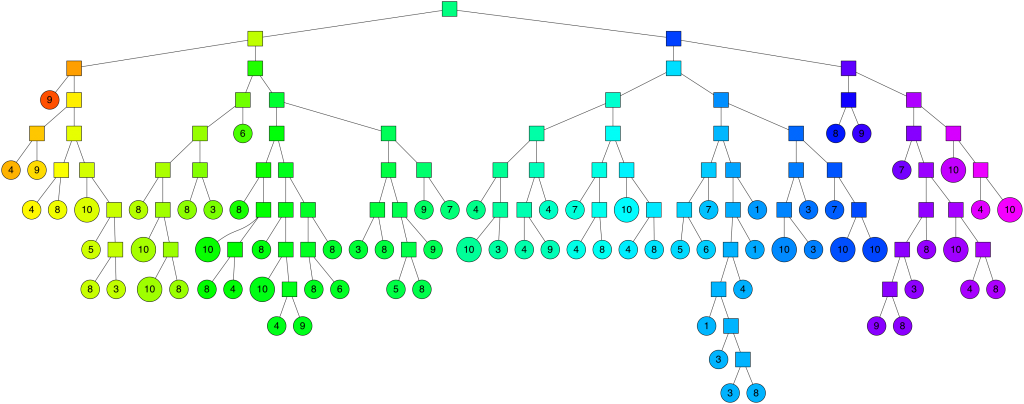



Source : Erik Bernhardsson. [*Nearest neighbors and vector models*](https://erikbern.com/2015/10/01/nearest-neighbors-and-vector-models-part-2-how-to-search-in-high-dimensional-spaces.html). 2015.

Il y a quelques détails supplémentaires à cet algorithme qui dépassent le cadre de ce TP, mais si vous souhaitez en savoir plus sur son fonctionnement interne, lisez cet excellent [article de blog](https://erikbern.com/2015/10/01/nearest-neighbors-and-vector-models-part-2-how-to-search-in-high-dimensional-spaces.html), par l'auteur lui-même d'ANNOY, Erik Bernhardsson.

Créons maintenant notre index ANNOY. Ce processus est lent et peut prendre jusqu'à 10 minutes (vous pouvez peut-être lire l'article de blog en attendant).

Nous créons d'abord l'`AnnoyIndex` où nous spécifions la taille de notre embedding (le $d$ de tout à l'heure) et la métrique de distance. Ici, `angular` fait référence à la similarité cosinus. Nous parcourons ensuite nos embeddings, en les ajoutant à notre index.

Ensuite, nous construisons notre index en spécifiant le nombre d'arbres qu'il doit créer. Dans l'explication précédente, nous avons montré qu'un seul arbre était construit, mais en réalité l'algorithme en utilise plusieurs. Plus il y a d'arbres, plus la précision est grande, mais cela nécessite plus de mémoire. En pratique, vous spécifierez le nombre d'arbres qui saturent votre mémoire ou jusqu'à ce que le niveau de précision souhaité soit atteint.
    


In [ ]:
from annoy import AnnoyIndex
from tqdm import tqdm

# (t, emb) => (index, vecteur)
t = AnnoyIndex(config.EMB_DIM, 'angular')
for i, emb in tqdm(enumerate(state.params['params']['item_embs']['embedding']), total=state.params['params']['item_embs']['embedding'].shape[0]):
    t.add_item(i, emb)

t.build(10)




Regardons à nouveau les films les plus similaires à ce film Avengers. Pour ce faire, nous appelons la méthode `get_nns_by_item` et spécifions le film que nous aimerions rechercher, les `n` voisins les plus proches (approximatifs) que nous aimerions renvoyer, et `search_k` qui fait référence au nombre d'embeddings qu'il prendra en compte pour le calcul de la distance. Le compromis est que plus le `search_k` est élevé, plus il sera précis, mais plus les performances seront lentes. Donc, en pratique, ce nombre sera choisi en s'assurant qu'il est aussi élevé que possible pour maximiser la précision tout en s'assurant que les résultats sont renvoyés dans un délai inférieur au seuil que vous avez défini pour votre application.


In [ ]:
config.USE_POSTERS = True
movie_id = movie_to_id_mapping["Avengers: Age of Ultron (2015)"]
display_recommendations(t.get_nns_by_item(movie_id, 5, search_k=10))


Comparons les résultats avec la recherche exacte que nous avons effectuée précédemment. Comment se comparent-ils ? Que se passe-t-il si nous modifions le `search_k` ci-dessus ?


In [ ]:
similar_ids = get_top_k_most_similar_movies("Avengers: Age of Ultron (2015)", state.params['params']['item_embs']['embedding'], 5)
display_recommendations(similar_ids)



### **2.7. Types de Feedback**

Pour construire des systèmes de recommandation, il existe deux types de feedback sur lesquels nous entraînons nos modèles.
- **Explicite**: les utilisateurs spécifient s'ils ont aimé ou non un article et parfois même dans quelle mesure. Des exemples de ceci sont un pouce levé ou un pouce baissé sur une vidéo YouTube, les notes d'un produit ou même une note de film!
- **Implicite**: le feedback est déduit de la manière dont les utilisateurs interagissent avec les articles. Par exemple, cliquer sur un article, regarder une vidéo, ajouter un produit à votre panier et/ou l'acheter.

La principale différence entre les deux est que le feedback explicite est plus rare mais vous donne une plus grande confiance dans l'intention des utilisateurs, tandis que les données implicites sont abondantes mais aussi plus bruyantes.

Habituellement, les deux types de feedback sont collectés dans les services en ligne que vous utilisez. Le feedback explicite provient des utilisateurs qui utilisent naturellement le produit (par exemple, en examinant le produit) tandis que les données implicites proviennent généralement de l'infrastructure de télémétrie qui surveille la manière dont les utilisateurs interagissent avec votre application. Selon la maturité de cette infrastructure, il peut s'agir simplement de consigner ce sur quoi vous cliquez, mais cela peut également inclure le temps que vous avez passé sur une page, l'emplacement d'où proviennent vos requêtes Web, le suivi exact du contenu auquel vous avez été exposé, et même si vous avez simplement survolé un élément et pendant combien de temps. Toutes ces données sont enregistrées et déversées dans des entrepôts de données massifs pour être ensuite nettoyées, analysées et éventuellement utilisées pour créer les modèles de recommandation.

Ces ensembles de données massifs sont constitués à la fois de feedback implicites et explicites, ainsi que des grands modèles de recommandation formés sur ceux-ci, ce qui explique pourquoi les recommandations peuvent parfois sembler si bonnes. Au cours de votre vie en ligne, vous exprimez constamment votre intérêt (ou votre désintérêt) implicitement par la simple utilisation de diverses plateformes Internet et c'est tout ce qui est nécessaire pour comprendre vos préférences (en particulier si l'on garde à l'esprit les milliers, voire les millions de personnes qui ont pu interagir avec la plateforme de manière similaire). Gardez maintenant à l'esprit la taille que ces ensembles de données et ces modèles peuvent atteindre. Dans ce TP, nous avons construit des modèles relativement petits sur seulement 1 Mo de données et étions toujours en mesure de faire des recommandations plausibles. Ils ne font que s'améliorer lorsque vous les mettez à l'échelle.

Il peut être angoissant de réaliser à quel point vos données sont collectées, mais au moins maintenant vous pouvez prendre une décision plus éclairée quant à savoir si la qualité des recommandations que vous obtenez vaut ce compromis. N'oubliez pas que le but de ces systèmes est de vous aider à trouver le contenu que vous recherchez et à découvrir du contenu que vous n'auriez peut-être pas trouvé autrement. Si cela ne vous convient toujours pas, heureusement, les réglementations évoluent et il se peut qu'il devienne obligatoire de permettre aux utilisateurs de refuser les recommandations personnalisées.


## Conclusion
**Résumé :**

Dans ce TP, nous avons présenté l'architecture générale des systèmes de recommandation et nous nous sommes spécifiquement concentrés sur la récupération d'éléments pertinents pour les utilisateurs. Nous avons fait cela en démontrant comment le filtrage collaboratif pouvait être utilisé pour cette tâche. Enfin, nous avons également décrit le type de données collectées et la manière dont elles sont traitées pour construire les ensembles de données utilisés pour construire les modèles de recommandation.

**Prochaines étapes :**

 - [GNN pour les systèmes de recommandation](https://github.com/engmubarak48/indaba-pracs-2024/blob/recommender-systems/practicals/GNN_for_recommendations.ipynb)
 - Blog RecSys d'[Eugene Yan](https://eugeneyan.com/tag/recsys/)
 - [Chaîne YouTube ACM RecSys](https://www.youtube.com/channel/UC2nEn-yNA1BtdDNWziphPGA)

**Références :**

- Jeremy Howard & Silvain Gugger. [*Deep Learning for Coders with fastai and PyTorch*](https://www.oreilly.com/library/view/deep-learning-for/9781492045519/). 2020. O'Reilly.
- Kim Falk. [*Practical Recommender Systems*](https://www.manning.com/books/practical-recommender-systems). 2019. Manning.
- [*Cours sur les systèmes de recommandation de Google*](https://developers.google.com/machine-learning/recommendation).


Pour d'autres travaux pratiques du Deep Learning Indaba, veuillez visiter [cette page](https://github.com/deep-learning-indaba/indaba-pracs-2024).
